## Good Resources

#### https://www.kaggle.com/code/prashant111/explain-your-model-predictions-with-shapley-values/notebook
#### https://towardsdatascience.com/explain-nlp-models-with-lime-shap-5c5a9f84d59b
#### https://medium.com/nlplanet/two-minutes-nlp-explain-predictions-with-shap-values-2a0e34219177

In [1]:
#Read in the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df1=pd.read_csv("https://raw.githubusercontent.com/statzenthusiast921/political-emails-analysis/main/main/data/clean_emails_df1.csv")
df2=pd.read_csv("https://raw.githubusercontent.com/statzenthusiast921/political-emails-analysis/main/main/data/clean_emails_df2.csv")
df3=pd.read_csv("https://raw.githubusercontent.com/statzenthusiast921/political-emails-analysis/main/main/data/clean_emails_df3.csv")
df4=pd.read_csv("https://raw.githubusercontent.com/statzenthusiast921/political-emails-analysis/main/main/data/clean_emails_df4.csv")

print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)

(19000, 20)
(19000, 20)
(19000, 20)
(17148, 20)


In [2]:
#Stack 4 dataframes together
df = pd.concat([df1, df2, df3, df4], ignore_index=True, axis=0)
#Delete first row and column
df = df[1:]
df = df.iloc[: , 1:]
#Preview dataframe
df.head(2)

,subject,date,body,party,country,locality,office,time,AM_PM,Hour,Hour_Mil,month,day,year,month_num,cleaned_body,sentiment,compound,comp_score
1,TAKE ACTION for Freedom: #CloseTheCamps,"July 3, 2019","Dear friend, We have all seen the images and r...",NaN,United States,NaN,NaN,11:31 PM,PM,11,23,July,3,2019,7,dear friend seen images read stories migrants ...,"{'neg': 0.207, 'neu': 0.674, 'pos': 0.12, 'com...",-0.9807,0
2,trauma-informed schools,"July 3, 2019","Team,Access to education is fundamental to a c...",Democratic,United States,Ohio,President of the United States,11:32 PM,PM,11,23,July,3,2019,7,team access education fundamental child succes...,"{'neg': 0.143, 'neu': 0.658, 'pos': 0.199, 'co...",0.7269,1


In [3]:
df = df[df['year']>1970]
import numpy as np
df['locality'] = np.where(df['locality']=="MIchigan","Michigan",df['locality'])

### SHAP values are about local interpretability of a predictive model, i.e. they explain how each feature influenced the single predictions.

In [4]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import shap
from sklearn.ensemble import RandomForestClassifier

/Users/jonzimmerman/Desktop/Data Projects/Political Emails/main/notebooks/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
X = df['cleaned_body'].values.astype('U').tolist()
y = df['comp_score'].to_numpy()

In [6]:
print(type(y))
print(type(X))

<class 'numpy.ndarray'>
<class 'list'>


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7, stratify=y)

In [8]:
print(type(X_train))
print(type(y_train))
print(type(X_test))
print(type(y_test))

<class 'list'>
<class 'numpy.ndarray'>
<class 'list'>
<class 'numpy.ndarray'>


In [9]:
#This is where the problem is
vectorizer = TfidfVectorizer(min_df=10)
X_train_vec = vectorizer.fit_transform(X_train).toarray()
X_test_vec = vectorizer.transform(X_test).toarray()

model = RandomForestClassifier()
model.fit(X_train_vec, y_train)

RandomForestClassifier()

#### In this step, we create an Explainer object with the model and the training data, so that it can retrain it if necessary. The Explainer object is then used to compute the SHAP values of the features (i.e. the single words of the reviews) using the test set. This step might take a while.

In [10]:
feature_names = vectorizer.get_feature_names_out()
explainer = shap.Explainer(model, X_train_vec, feature_names=feature_names)
shap_values = explainer(X_test_vec)
print(shap_values.values.shape) # (14830, 30613, 2)

100%|===================| 29655/29660 [96:05<00:00]        

(14830, 30613, 2)


#### Eventually, we can plot the SHAP values of the features for each prediction. Let’s consider a positive review now.

In [27]:
print(y_test[0])
print(y_test[2])

0
1


capitalism newsthis past week capitalism magazine abortion rights pro life leonard peikoffabortion rights advocates cede terms pro life right life anti abortionists woman right life gives right terminate pregnancy much damage come trade war richard ebelingfirst good news world economies imploded far fallout rising trade tensions trump administration xi jinping government china bad news certainty play serious damaging trade war sell organ john stosselmost die waiting important today racial discrimination walter williamshow much plight many blacks explained current racial discrimination news stupid shallow john stosselmost reporters like free markets politicians rarely talk change control forward share http f feepurl fganfap tweet http f feepurl fganfap share


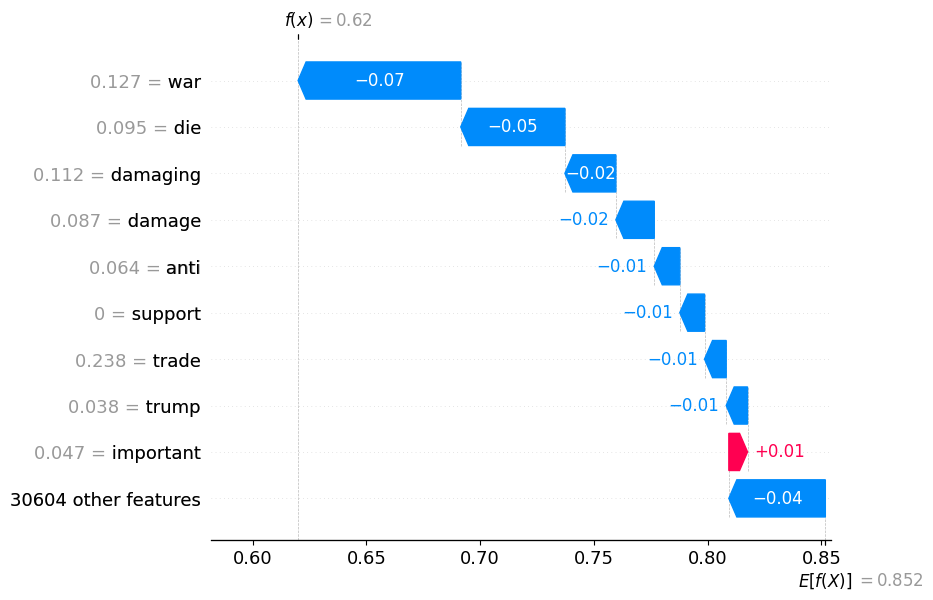

In [28]:
shap.initjs()

ind = 0
print(X_test[ind])
shap.plots.waterfall(shap_values[ind,:,1])

In [ ]:
#Average model prediction shifts from 0.852 overall to 0.62 for this specific sample 
#the word "war" had the most to do with it

dear friend today filed run another term represent louisville united states congress went congress louisville values fight president intent destroying nation faces pressing challenges need response tackling climate crisis fixing broken immigration system repairing crumbling infrastructure reducing prescription drug prices addressing gun violence epidemic much work future wait chairman house budget committee plan continue use platform focus congress economic impacts rapidly changing world coming year bring real positive change community commonwealth country next congress sooner look forward working new president defend democracy join us advancing nation priorities continue fight congress need help please join effort bring louisville values washington


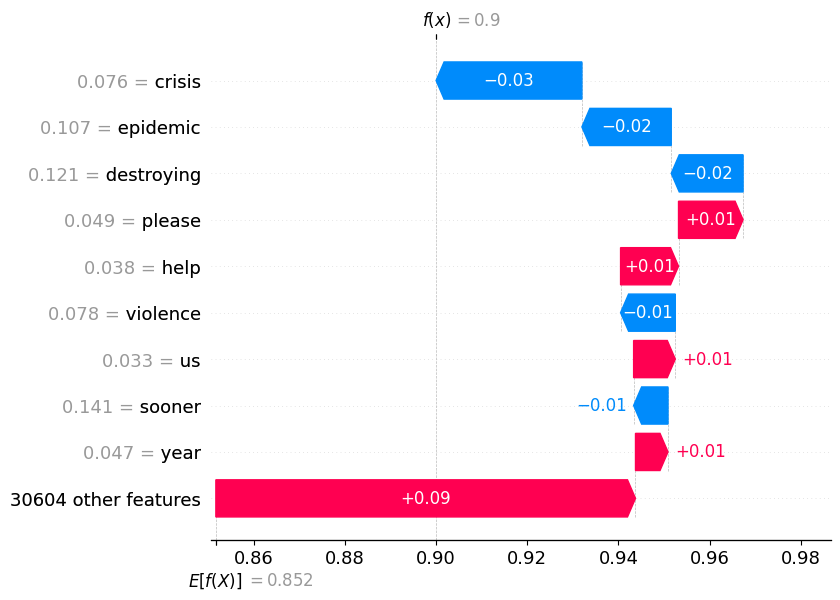

In [29]:
shap.initjs()

ind = 2
print(X_test[ind])
shap.plots.waterfall(shap_values[ind,:,1])

#### Each point in the plot below represents the word “war” in a different sample of the test set. Its x-coordinate represents the TF-IDF value of the specific sample, while the y-coordinate represents its SHAP value.

#### Almost every time the word “war” is present in a sample (i.e. when its TF-IDF score is greater than zero), it contributes to a shift of the prediction towards the negative label.

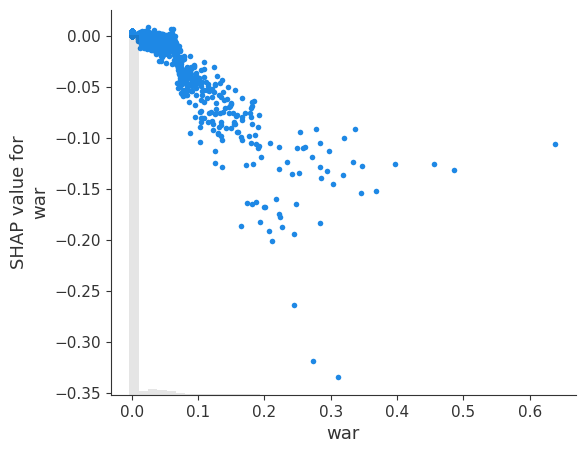

In [30]:
shap.plots.scatter(shap_values[:,feature_names.tolist().index("war"),1])

#### This chart is not as clear as the previous.  Each time the word “please” is present in a sample (i.e. when its TF-IDF score is greater than zero), it contributes to a a slight shift of the prediction towards the positive label, but not by a lot.

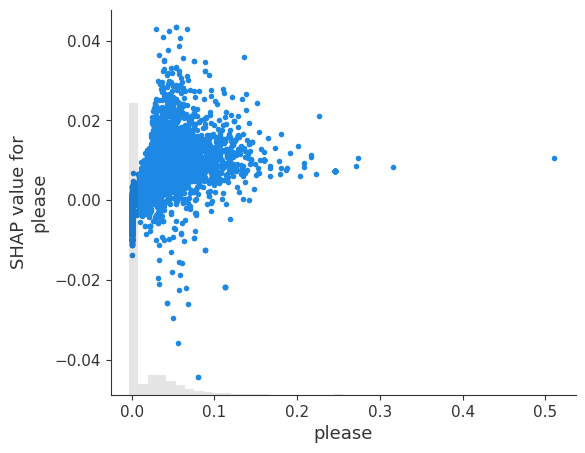

In [31]:
shap.plots.scatter(shap_values[:,feature_names.tolist().index("please"),1])
